In [1]:
import sys

sys.path.append("..")
sys.path.append("../..")
sys.path.append("../../src")

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from functional_autoencoders.util import pickle_load
from plots import set_plot_style_publication, plot_runs_and_medians

In [2]:
def generate_discrete_dirac(idx, pts):
    x = np.linspace(0, 1, pts + 2)[1:-1]
    u = np.zeros_like(x)
    u[idx] = pts + 1
    return x, u


def generate_gaussian_density(mu, sigma, pts_coarse, pts_fine):
    x_coarse = np.linspace(0, 1, pts_coarse + 2)[1:-1]
    x_fine = np.linspace(0, 1, pts_fine)
    z_coarse = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(
        -((x_coarse - mu) ** 2) / (2 * sigma**2)
    )
    z_fine = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(
        -((x_fine - mu) ** 2) / (2 * sigma**2)
    )

    return x_coarse, z_coarse, x_fine, z_fine


def plot_schematic(ax, mu=0.47, s=0.1, theta_idx=4, theta_pts=8):
    theta = (theta_idx + 1) / (theta_pts + 1)
    x, u = generate_discrete_dirac(theta_idx, theta_pts)
    ax.set_xmargin(0)
    ax.set_yticks([theta_pts + 1])
    ax.set_ylim([0, theta_pts + 2])
    ax.set_xticks([0, theta, mu, 1])
    ax.set_xticklabels(["0", r"$\theta$", "", "1"])
    ax.set_xlim([0, 1])
    ax.yaxis.set_tick_params(right=False)
    x, z, x_fine, z_fine = generate_gaussian_density(mu, s, theta_pts, 1000)
    ax.text(
        mu + 0.12, np.max(z_fine) - 1.5, "reconstruction\n$g(z; \\theta_{g})$", c="r"
    )
    ax.scatter(x, z, marker="s", c="r")
    ax.axvline(mu, c="r")
    ax.text(mu - 0.265, 6.4, "learnable\nmean $\\mu$", c="r")
    ax.plot(x_fine, z_fine, "r--")

    ht = 2.7
    ax.annotate(
        text="",
        xy=(mu - s, ht),
        xytext=(mu + 0.01, ht),
        arrowprops={
            "arrowstyle": "<->",
            "color": "r",
        },
    )
    ax.text(mu - s - 0.23, ht - 0.3, "learnable\nSD $\\sigma$", c="r")
    ax.scatter(x, u, c="k", marker="s")
    ax.text(
        theta + 0.03, theta_pts + 0.5, "discretisation\nof Dirac $\\delta_{\\theta}$"
    )
    ax.set_xlabel("$x$")


def get_dirac_losses(output_dir):
    data_output_dir = os.path.join(output_dir, "data")

    losses = {}
    for pts in os.listdir(data_output_dir):
        for run_idx_str in os.listdir(os.path.join(data_output_dir, pts)):
            path_results = os.path.join(
                data_output_dir, pts, run_idx_str, "data.pickle"
            )
            results = pickle_load(path_results)
            loss = results["training_results"]["training_loss_history"][-1].item()

            if int(pts) not in losses:
                losses[int(pts)] = []

            losses[int(pts)].append(loss)

    losses = {k: losses[k] for k in sorted(losses.keys())}
    return losses

In [3]:
losses_fae = get_dirac_losses("../../tmp/experiments/exp_dirac/fae")
losses_vano = get_dirac_losses("../../tmp/experiments/exp_dirac/vano")

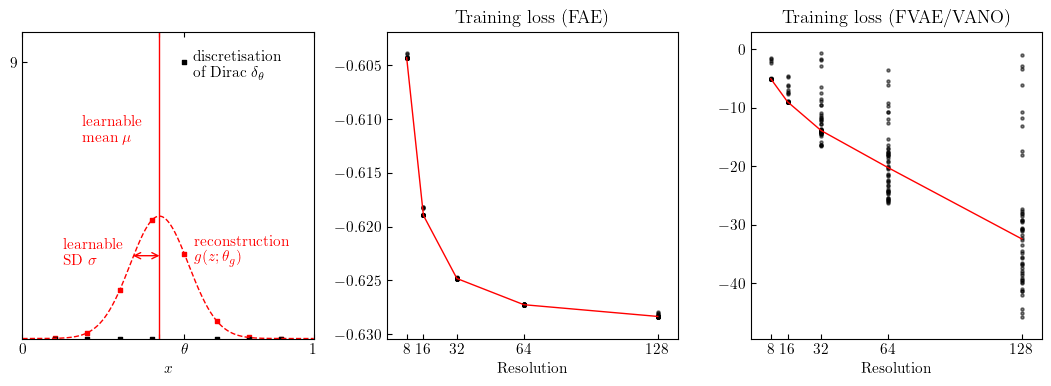

In [5]:
SAVE_DIR = None
# SAVE_DIR = '../../figures/dirac'
# os.makedirs(SAVE_DIR, exist_ok=True)

set_plot_style_publication()

fig, (ax_schematic, ax_fae, ax_vano) = plt.subplots(1, 3)
plot_schematic(ax_schematic)
plot_runs_and_medians(ax_fae, losses_fae, "Training loss (FAE)", labelx="Resolution")
plot_runs_and_medians(ax_vano, losses_vano, "Training loss (FVAE/VANO)", labelx="Resolution")

fig.tight_layout()
fig.set_size_inches(11, 3.8)
fig.subplots_adjust(wspace=0.25)

if SAVE_DIR is not None:
    fig.savefig(f"{SAVE_DIR}/dirac_loss.pdf")